<a href="https://colab.research.google.com/github/arelkeselbri/gsi073/blob/main/GSI073_aula0_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preparação dos dados

Esta tarefa é inverter sequências de caracteres. Exemplo: **aabcd** em **dcbaa**.


In [20]:
import torch
import torch.nn as nn
import random
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

chars = list("abcde ")
vocab = {ch: i for i, ch in enumerate(chars)} # Cada letra, ganha um número
inv_vocab = {i: ch for ch, i in vocab.items()}# Tabela de decodificação
vocab_size = len(vocab)

def encode(s): # Codifica letras em números
    return torch.tensor([vocab[c] for c in s], dtype=torch.long)
    
def decode(t): # Decodifica números em letras
    return ''.join(inv_vocab[int(x)] for x in t)
    
def random_seq(n=5): # Cria novas sequências
    return ''.join(random.choice(chars[:-1]) for _ in range(n))
    
# Gerar dados
pairs = [(encode(s), encode(s[::-1])) for s in [random_seq() for _ in range(50000)]]

max_len = max(len(x) for x, _ in pairs) # pega maior sequência
def pad(x):  # Preenche conjunto de dados em pad no último índice
    return torch.cat([x, torch.tensor([vocab[' ']] * (max_len - len(x)))], dim=0)

inputs = torch.stack([pad(x) for x, _ in pairs])
targets = torch.stack([pad(y) for _, y in pairs])

train_ds = torch.utils.data.TensorDataset(inputs, targets)
train_dl = torch.utils.data.DataLoader(train_ds, batch_size=128, shuffle=True)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

## Veja um par

In [21]:
print(f"Exemplo de par de dados (codificado): {pairs[1]}")
print(f"Decodificado: {decode(pairs[1][0])} -> {decode(pairs[1][1])}")

Exemplo de par de dados (codificado): (tensor([4, 0, 3, 0, 3]), tensor([3, 0, 3, 0, 4]))
Decodificado: eadad -> dadae


# Definição do modelo Seq2Seq com GRU

In [22]:
class Encoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, batch_first=True)

    def forward(self, x):
        x = self.embed(x)
        _, h = self.gru(x)
        return h  # [1, B, H]

class Decoder(nn.Module):
    def __init__(self, vocab_size, emb_size, hidden_size):
        super().__init__()
        self.embed = nn.Embedding(vocab_size, emb_size)
        self.gru = nn.GRU(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, vocab_size)

    def forward(self, x, h):
        """
        x: tensor que indica a parte prévia correta
        h: tensor que indica o estado do encoder da parte prévia
        """
        x = self.embed(x)
        out, h = self.gru(x, h)
        logits = self.fc(out)
        return logits, h # retorna o estado latente para atualizar o estado

class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder

    def forward(self, src, tgt):
        h = self.encoder(src)
        # usa contexto correto anterior e estado atual para prever o tgt[:, -1]
        logits, _ = self.decoder(tgt[:, :-1], h)
        return logits

# Código para usar o modelo treinado: inferência

In [23]:
def decode_step(decoder, token, h):
    logits, h = decoder(token, h) # obtém logits e atualiza estado da sequência
    next_token = logits[:, -1, :].argmax(-1, keepdim=True)
    return next_token, h
    
def predict(model, seq, max_len=10):
    model.eval()
    with torch.no_grad():
        src = pad(encode(seq)).unsqueeze(0).to(device, dtype=torch.long)
        h = model.encoder(src) # Obtém estado do modelo após processar entrada inicial

        # 'token' representa a geração passo a passo da sequência invertida
        token = torch.tensor([[vocab[' ']]], dtype=torch.long, device=device)
        seq_invertida = []
        for _ in range(max_len):
            token, h = decode_step(model.decoder, token, h)
            seq_invertida.append(token.item())
        return decode(seq_invertida)

# Preparação para treino

In [24]:
emb_size = 32
hidden_size = 64
encoder = Encoder(vocab_size, emb_size, hidden_size)
decoder = Decoder(vocab_size, emb_size, hidden_size)
model = Seq2Seq(encoder, decoder).to(device)

loss_fn = nn.CrossEntropyLoss(ignore_index=vocab[' ']) # ignora o pad: " "
opt = torch.optim.Adam(model.parameters(), lr=1e-3)

# Execução do treino

In [25]:
print("\nIniciando Treinamento...")
for epoch in range(20):
    model.train()
    total_loss = 0
    for xb, yb in train_dl:
        xb, yb = xb.to(device, dtype=torch.long), yb.to(device, dtype=torch.long)
        opt.zero_grad()
        logits = model(xb, yb)
        loss = loss_fn(logits.reshape(-1, vocab_size), yb[:, 1:].reshape(-1))
        loss.backward()
        opt.step()
        total_loss += loss.item()
    print(f"Epoch {epoch+1}: loss={total_loss/len(train_dl):.4f}")
print("Treinamento concluído.")


Iniciando Treinamento...
Epoch 1: loss=0.3954
Epoch 2: loss=0.0137
Epoch 3: loss=0.0031
Epoch 4: loss=0.0017
Epoch 5: loss=0.0010
Epoch 6: loss=0.0007
Epoch 7: loss=0.0005
Epoch 8: loss=0.0003
Epoch 9: loss=0.0002
Epoch 10: loss=0.0002
Epoch 11: loss=0.0001
Epoch 12: loss=0.0001
Epoch 13: loss=0.0001
Epoch 14: loss=0.0001
Epoch 15: loss=0.0000
Epoch 16: loss=0.0000
Epoch 17: loss=0.0000
Epoch 18: loss=0.0000
Epoch 19: loss=0.0000
Epoch 20: loss=0.0000
Treinamento concluído.


# Vamos testar

In [26]:
print("\n--- Teste de Inferência ---")
for _ in range(5):
    s = random_seq()
    pred = predict(model, s, max_len=len(s))
    print(f"{s} -> {pred}")


--- Teste de Inferência ---
dbeba -> abebd
bedcd -> dcdee
deebc -> cbeed
ccbea -> aeceb
bbcea -> aeccd


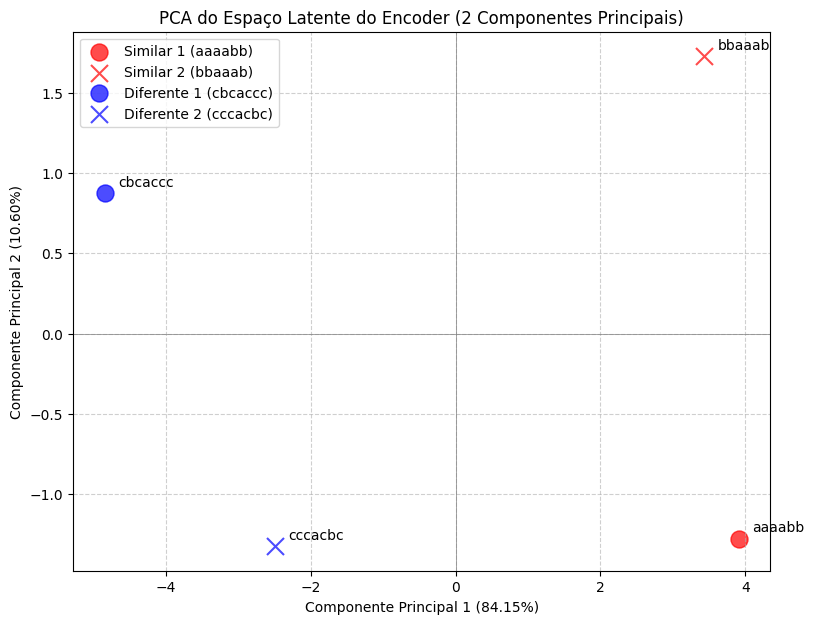

In [ ]:
# PCA

def get_latent_state(model, seq):
    """Extrai o estado latente (h) final do Encoder para uma dada sequência.
       Esta função precisa ser definida no escopo antes de ser usada."""
    model.eval()
    with torch.no_grad():
        src = pad(encode(seq)).unsqueeze(0).to(device, dtype=torch.long)
        # O encoder retorna o estado h: [1, B, H]
        h = model.encoder(src) 
        # Squeeze para [B, H] e converte para NumPy no CPU
        return h.squeeze(0).cpu().numpy() 

# Sequências para análise
sequences = ["aaaabb", "bbaaab", "cbcaccc", "cccacbc"]
labels = ["Similar 1 (aaaabb)", "Similar 2 (bbaaab)", 
          "Diferente 1 (cbcaccc)", "Diferente 2 (cccacbc)"]

# Extração dos estados latentes
latent_states = [get_latent_state(model, s) for s in sequences] 

# Combinar em uma matriz para o PCA (shape: [4, hidden_size=64])
X = np.vstack(latent_states)

# APLICAÇÃO DO PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Geração do gráfico
plt.figure(figsize=(9, 7))
colors = ['red', 'red', 'blue', 'blue']
markers = ['o', 'x', 'o', 'x']

for i in range(len(sequences)):
    # Plotar o ponto
    plt.scatter(X_pca[i, 0], X_pca[i, 1], 
                c=colors[i], marker=markers[i], 
                label=labels[i], s=150, alpha=0.7)
    # Adicionar o texto da sequência
    plt.annotate(sequences[i], (X_pca[i, 0], X_pca[i, 1]), 
                 textcoords="offset points", xytext=(10, 5), ha='left')

# Detalhes do gráfico
plt.title('PCA do Espaço Latente do Encoder (2 Componentes Principais)')
var_ratio_1 = pca.explained_variance_ratio_[0]*100
var_ratio_2 = pca.explained_variance_ratio_[1]*100
plt.xlabel(f'Componente Principal 1 ({var_ratio_1:.2f}%)')
plt.ylabel(f'Componente Principal 2 ({var_ratio_2:.2f}%)')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)
plt.axhline(0, color='gray', linewidth=0.5)
plt.axvline(0, color='gray', linewidth=0.5)
plt.show()